In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Part 1. Let's train some decision trees.

In this part, I will do the simplest preprocessig of the dataset and train decision trees. In the task, I'm going to predict whether income of a person exceeds \$50K/year. The target variable is equal to `1` if a person earns > \$50k/year and `0` otherwise. 

As an evaluation criterion, we will be using $F_1$score. As you know, it is a weighted average of precision and recall. We are not using accuracy, because the dataset is imbalanced. 

In [2]:
train_data = pd.read_csv('https://github.com/mbburova/MDS/raw/main/week5_train.csv')
train_data.head()

,age,workclass,education,education_years,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0.0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0.0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0.0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0.0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0.0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              32561 non-null  int64  
 1   workclass        30725 non-null  object 
 2   education        32561 non-null  object 
 3   education_years  32561 non-null  int64  
 4   marital_status   32561 non-null  object 
 5   occupation       30718 non-null  object 
 6   relationship     32561 non-null  object 
 7   race             32561 non-null  object 
 8   sex              32561 non-null  object 
 9   capital_gain     32561 non-null  int64  
 10  capital_loss     32561 non-null  int64  
 11  hours_per_week   32561 non-null  int64  
 12  native_country   31978 non-null  object 
 13  target           32561 non-null  float64
dtypes: float64(1), int64(5), object(8)
memory usage: 3.5+ MB


In [8]:
train_data.isnull().sum()

age                   0
workclass          1836
education             0
education_years       0
marital_status        0
occupation         1843
relationship          0
race                  0
sex                   0
capital_gain          0
capital_loss          0
hours_per_week        0
native_country      583
target                0
dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

tr, val = train_test_split(train_data, test_size=0.4, random_state=42)

y_train = tr.target
y_valid = val.target
X_train = tr.drop(['target'], axis=1)
X_valid = val.drop(['target'], axis=1)

---
**Step 1:** In this step I'll create `column_transformer` with the following steps:
- fills all the missing values 
- encodes all the categorical features using OHE 
- scales numerical features.
___

In [22]:
categ_col = X_train.columns[X_train.dtypes == "object"].tolist()
numer_col = X_train.columns[(X_train.dtypes == "float64") | (X_train.dtypes == "int64")].tolist()
print(categ_col, "\n", numer_col)

['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'] 
 ['age', 'education_years', 'capital_gain', 'capital_loss', 'hours_per_week']


In [23]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

In [26]:
# create pipelines for each data type
categ_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
numer_pipe = make_pipeline(StandardScaler())

# combine the pipelines in one column transformer
column_transformer = ColumnTransformer([
    ('categ', categ_pipe, categ_col),
    ('numer', numer_pipe, numer_col)],
    remainder='passthrough'
)

In [27]:
X_transformed = column_transformer.fit_transform(X_train)
X_transformed.shape

X_transformed = column_transformer.fit_transform(X_train)
assert X_transformed.shape[0] == 19536
assert X_transformed.shape[1] == 104

---
**Step 2:** In this step I'll create a function `tree_pipe`, which given with a maximal tree depth returns a pipeline with two steps:

1. Column transformer (defined above)
2. DecisionTreeClassfier with the required `max_depth` parameter
___

In [28]:
from sklearn.tree import DecisionTreeClassifier

def tree_pipe(max_depth):
    pipeline = make_pipeline(column_transformer, DecisionTreeClassifier(max_depth=max_depth))
    return pipeline

In [29]:
test_pipe = tree_pipe(1)

test_pipe = tree_pipe(12)
tree = test_pipe.steps[1][1]
assert tree.max_depth == 12

---
**Step 3:** Now, let's fit decision trees of different depth (from 1 to 100) using the function from the **step 2**. For each depth calculate $F_1$score on the train and validation datasets. Draw a plot, how both scores depend on the maximal tree depth.
___

In [52]:
from sklearn.metrics import f1_score

f1_train = list()
f1_valid = list()
for i in range(1, 101):
    # train model
    model = tree_pipe(i)
    model.fit(X_train, y_train)
    
    # calculate score for train dataset
    y_predict = model.predict(X_train)
    f1_train.append(f1_score(y_predict, y_train))
    
    # calculate score for valid dataset
    y_predict = model.predict(X_valid)
    f1_valid.append(f1_score(y_predict, y_valid))

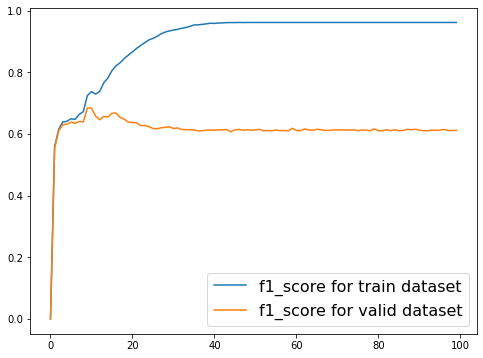

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(f1_train, label="f1_score for train dataset")
plt.plot(f1_valid, label="f1_score for valid dataset")
plt.legend(fontsize=16);